In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from mbti_util import MbtiUtil
from denoicer import Denoicer
from SentenceBertJapanese import SentenceBertJapanese
import matplotlib.pyplot as plt
from adjustText import adjust_text


In [2]:
mbti_util = MbtiUtil()
denoicer = Denoicer()

In [3]:
def read_tweets_with_before_after():
    path = './database/tweets_with_before_or_after.tsv'
    df = pd.read_csv(path, sep='\t')
    return df

df = read_tweets_with_before_after()
df.head(5)

,Unnamed: 0,user_id,m_type,tweet_id,tweet_text,m_type_en,before_or_after
0,0,940954542576885760,仲介者,1197852103021981696,@yryr_8945 担当制なんだ！笑この量でこのクオリティは本当すごい🎅お疲れ様です☺️,INFP,before
1,1,940954542576885760,仲介者,1197318394946543617,@yryr_8945 えっ！自作！すごい！,INFP,before
2,2,940954542576885760,仲介者,1196803484332388352,@stella_kakerun 明日休みだから行ってみる😭ありがとう！,INFP,before
3,3,940954542576885760,仲介者,1196785937482575874,ファミマ行く暇なかったよー😭,INFP,before
4,4,940954542576885760,仲介者,1196389448344207370,シュヴァルツヴェルダーキルシュトルテかな？ https://t.co/ggxZQ2v6hL,INFP,before


In [4]:
MODEL_NAME = "sonoisa/sentence-bert-base-ja-mean-tokens"
model = SentenceBertJapanese(MODEL_NAME)

def calc_avg_vec_each_personality(df: pd.DataFrame, before_or_after: str) -> dict:
    avg_vecs = {}
    for m_type in tqdm(sorted(mbti_util.m_types)):
        df_type = df[df['m_type_en']==m_type]
        tweets = df_type[df_type['before_or_after']==before_or_after]['tweet_text'].to_list()
        normalized_tweets = [denoicer.normalize_text(tweet) for tweet in tweets]
        normalized_tweets = list(filter(None, normalized_tweets))

        sum_vec = np.zeros(768)
        result = model.encode(normalized_tweets).numpy()
        for r in result:
            sum_vec += r
        avg_vec = sum_vec / len(result)
        avg_vecs[m_type] = avg_vec
    print(f'{before_or_after} completed.')
    return avg_vecs

before_avg_vecs = calc_avg_vec_each_personality(df=df, before_or_after='before')
after_avg_vecs = calc_avg_vec_each_personality(df=df, before_or_after='after')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertJapaneseTokenizer'.
100%|██████████| 16/16 [04:12<00:00, 15.75s/it]


before completed.


100%|██████████| 16/16 [04:13<00:00, 15.84s/it]

after completed.


In [10]:
# コロナ禍後の距離の算出
for m_type in tqdm(sorted(mbti_util.m_types)):
    distance = np.linalg.norm(after_avg_vecs[m_type] - before_avg_vecs[m_type])
    print(m_type, distance)

100%|██████████| 16/16 [00:00<00:00, 22031.80it/s]

ENFJ 0.5549380152691977
ENFP 0.612843591217855
ENTJ 0.5124901105597992
ENTP 0.4784727473585833
ESFJ 0.5652617433391436
ESFP 0.5227193802339953
ESTJ 0.7706041317785912
ESTP 0.5988392317883799
INFJ 0.4722136677014174
INFP 0.3403289642368753
INTJ 0.44097156641015883
INTP 0.5101766175690802
ISFJ 0.4517829881549027
ISFP 0.5301923941330321
ISTJ 0.44572154441166606
ISTP 0.442603162508778


In [ ]:
# コロナ禍後の性格ごとの距離の算出
data = []
for m_type0 in tqdm(sorted(mbti_util.m_types)):
    d = []
    for m_type1 in tqdm(sorted(mbti_util.m_types)):
        distance = np.linalg.norm(
            after_avg_vecs[m_type0] - after_avg_vecs[m_type1])
        d.append(distance)
    data.append(d)

import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(data=data, index=sorted(mbti_util.m_types), columns=sorted(mbti_util.m_types))
plt.rcParams["font.size"] = 16
plt.figure(figsize=[16, 9])
sns.heatmap(df)
plt.savefig('covid_after_head_map.eps')

In [5]:
# SVD で次元削減
def svd_decomposition(vecs):
    np.set_printoptions(suppress=True)
    svd = TruncatedSVD(n_components=2, random_state=1)
    svd.fit(vecs)
    return svd.transform(vecs)

In [6]:
vecs = list(before_avg_vecs.values()) + list(after_avg_vecs.values())
decomposition_vecs = svd_decomposition(vecs)

In [21]:
with open('aaa.txt', 'w', encoding='utf8') as f:
    for m_type, vec in zip(sorted(mbti_util.m_types), decomposition_vecs[:16]):
        f.write(f'{m_type}(B)\t{vec[0]}\t{vec[1]}\n')
    for m_type, vec in zip(sorted(mbti_util.m_types), decomposition_vecs[16:]):
        f.write(f'{m_type}(A)\t{vec[0]}\t{vec[1]}\n')

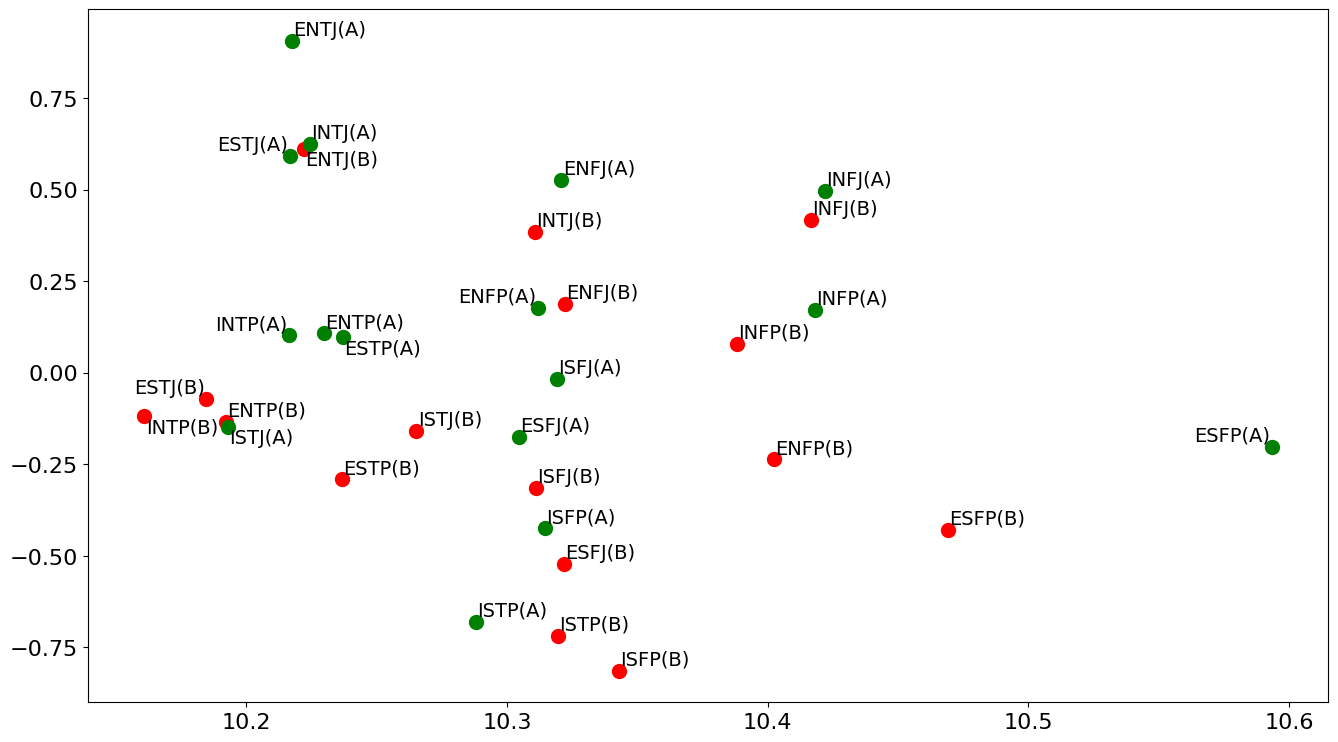

In [25]:
# プロット
import matplotlib.pyplot as plt
from adjustText import adjust_text
plt.rcParams["font.size"] = 16

x = [vec[0] for vec in decomposition_vecs]
y = [vec[1] for vec in decomposition_vecs]
label = [m_type+"(B)" for m_type in sorted(mbti_util.m_types)] + [m_type+"(A)" for m_type in sorted(mbti_util.m_types)]

fig, ax = plt.subplots(figsize=(16, 9))
# plt.scatter(x[:16], y[:16], s=80, color='red')
# plt.scatter(x[16:], y[16:], s=80, color='green')
# plt.grid(True)
#for i, l in enumerate(label):
#    plt.annotate(l, (x[i], y[i]))

texts = []
count = 0
for x, y, l in zip(x, y, label):
    if count < 16:
        ax.plot(x, y, marker='o', linestyle='', ms=10, color='red')
    else:
        ax.plot(x, y, marker='o', linestyle='', ms=10, color='green')
    count += 1
    plt_text = ax.annotate(l, (x, y), fontsize=14, color='black')
    texts.append(plt_text)
# plt.scatter(x[:16], y[:16], s=80, color='red')

# arrowpropsでラベルからプロットした点を指す線などの形状や色を指定
adjust_text(texts)
plt.savefig('test.svg')